### Implement Batch Gradient Descent ***with*** early stopping ***for*** Softmax Regression
(without using Scikit-Learn)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Figure saving funciton
def savefig(NAME="figure", TRANSPARENT=True):
    os.makedirs("Softmax_BGD_earlystopping_figures", exist_ok=True)
    path = os.path.join("Figures", NAME)
    plt.savefig(path, transparent=TRANSPARENT)

## Getting the dataset


Using the entire iris dataset.

Features containing all 4 features of iris dataset. labels contain `iris-setosa`, `iris-versicolor` and `iris-verginica`

In [2]:
iris = pd.read_csv("datasets/iris.csv")
iris.head()#, iris.describe()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Splitting into features-labels

In [3]:
X = np.array(iris.drop(["class"], axis=1).copy())
y = np.array(iris["class"]).reshape(-1, 1)


X[:5], y[:5], X.shape, y.shape

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array([['Iris-setosa'],
        ['Iris-setosa'],
        ['Iris-setosa'],
        ['Iris-setosa'],
        ['Iris-setosa']], dtype=object),
 (150, 4),
 (150, 1))

### Preparing the data

##### One-hot encoding for`y`

1 if class, 0 if non-class

In [4]:
def One_hot_encoder(y):
    
    if y.dtype != np.int64:
        _, y = np.unique(y, return_inverse=True)
    
    n_classes = y.max() + 1 # total classses
    m = len(y) # length of set
    Y_one_hot = np.zeros((m, n_classes)) # zeros matrix
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

y = One_hot_encoder(y)

In [5]:
X.shape, y.shape

((150, 4), (150, 3))

##### Train-Test splitting

In [25]:
def split_train_test(X, y, test_ratio=0.2, validation_ratio=0.2, RANDOM_STATE=42):
    
    np.random.seed(RANDOM_STATE)
    m = len(X)
    indices = np.random.permutation(m) # to get shuffled indices
    s = int((1-test_ratio)*m) # train_set size
    
    # shuffling sets
    X = np.array([X[i] for i in indices])
    y = np.array([y[i] for i in indices])
    
    #splitting sets
    X_train, X_test = X[:s], X[s:]
    y_train, y_test = y[:s], y[s:]
    
    #similarly, splitting into training and validation
    
    s_val = int((1-validation_ratio)*s)
    X_train, X_val = X_train[:s_val], X_train[s_val:]
    y_train, y_val = y_train[:s_val], y_train[s_val:]
    
    return X_train, X_test, X_val, y_train, y_test, y_val 

X_train, X_test, X_val, y_train, y_test, y_val  = split_train_test(X, y)

In [26]:
X_train[:5], y_train[:5]

(array([[6.1, 2.8, 4.7, 1.2],
        [5.7, 3.8, 1.7, 0.3],
        [7.7, 2.6, 6.9, 2.3],
        [6. , 2.9, 4.5, 1.5],
        [6.8, 2.8, 4.8, 1.4]]),
 array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]]))

In [28]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((96, 4), (30, 4), (24, 4), (96, 3), (30, 3), (24, 3))

## Training...

Softmax function

parameter: `logits` - the softmax score

In [29]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

Adding bias to `X_train`

In [32]:
X_b = np.c_[np.ones((len(X_train), 1)), X_train]
X_b[:5], X_b.shape

(array([[1. , 6.1, 2.8, 4.7, 1.2],
        [1. , 5.7, 3.8, 1.7, 0.3],
        [1. , 7.7, 2.6, 6.9, 2.3],
        [1. , 6. , 2.9, 4.5, 1.5],
        [1. , 6.8, 2.8, 4.8, 1.4]]),
 (96, 5))

### Plain Batch Gradient Descent implementation

Using the **cost function** and **gradients equation** for ***Softmax Regression***

In [40]:
eta = 0.01 # Learning rate
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7 # since log(0) is inf, compute log(epsilon instead)

# parameter dimensions: no_of_features+bias X no_of_outputs
theta = np.random.randn(5, 3)

# paths
loss_path = []

for iteration in range(n_iterations):
    logits = X_b.dot(theta)
    
    # probability vector
    p_k = softmax(logits)
    
    # Also, printing the loss for every 500th iteration
    loss = -np.mean(np.sum(y_train * np.log(p_k + epsilon) , axis=1)) # because loss already -ve
    loss_path.append(loss)
    if iteration%500 == 1:
        print(f"i={iteration}, loss={loss}")
        
    # error (for all instances)
    error = p_k - y_train
    
    # gradient vector
    gradients = 1/m * X_b.T.dot(error)
    
    # updating theta
    theta = theta - eta*gradients

i=1, loss=2.337304707445033
i=501, loss=0.4668149151970716
i=1001, loss=0.3804003614058972
i=1501, loss=0.32813455991474877
i=2001, loss=0.291521959581654
i=2501, loss=0.26427733795626357
i=3001, loss=0.2431981149149047
i=3501, loss=0.22640085652830266
i=4001, loss=0.21269579114000314
i=4501, loss=0.2012944589364678


Plotting the error across epochs

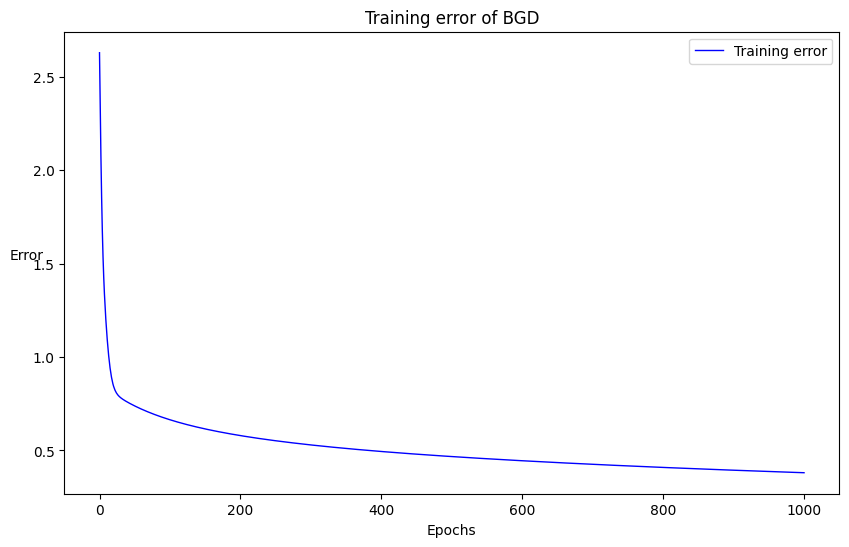

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1001), loss_path[:1001], 'b', lw=1, label="Training error")
plt.xlabel("Epochs")
plt.ylabel("Error", rotation=0)
plt.legend()
plt.title("Training error of BGD")

savefig("1error_vs_epoch_BGD")

Looking at final parameter vector

In [49]:
theta

array([[ 0.84034922, -0.36465046, -0.23350544],
       [ 0.6791701 ,  0.06161036, -2.17549461],
       [ 1.38760213,  0.38653006, -0.53089481],
       [-1.28296113,  1.47664531,  4.23581323],
       [-1.20231798, -1.26412199,  0.49604085]])

#### Making predictions on the validation set

In [62]:
X_b_val = np.c_[np.ones((len(X_val), 1)), X_val]

logits = X_b_val.dot(theta)
Y_proba = softmax(logits)
y_predict = One_hot_encoder(np.argmax(Y_proba, axis=1))

accuracy_score = np.mean(y_predict == y_val)
"accuracy: ", accuracy_score
# y_predict.shape, y_val.shape, p_k.shape

('accuracy: ', 1.0)

### BGD with $l_2$ regularisation

In [72]:
eta = 0.1 # higher eta than last time
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # Regularisation hyperparameter

theta = np.random.randn(5, 3)

loss_path_l2 = []

for iteration in range(n_iterations):
    logits = X_b.dot(theta)
    
    p_k = softmax(logits)
    
    # the cost function of Softmax
    xentropy_loss = -np.mean(np.sum(y_train * np.log(p_k + epsilon), axis=1))
    # l2 penalty loss
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    # total loss
    loss = xentropy_loss + alpha * l2_loss
    loss_path_l2.append(loss)
    
    if iteration%500 == 1:
        print(f"i={iteration}, loss={loss}")
        
    error = p_k - y_train
    
    # DIFFERENT graient vector
    gradients = 1/m * X_b.T.dot(error) + np.r_[np.zeros([1, 3]), alpha * theta[1:]]
    
    theta = theta - eta*gradients

theta

i=1, loss=2.83991357173923
i=501, loss=0.6727226433406491
i=1001, loss=0.6264629671468122
i=1501, loss=0.5870201156392805
i=2001, loss=0.5543212297158574
i=2501, loss=0.5278628790100588
i=3001, loss=0.5068632442008741
i=3501, loss=0.4904965569105495
i=4001, loss=0.47843216875450895
i=4501, loss=0.47354302770892065


array([[ 3.20474499,  1.52228048, -4.74739075],
       [-0.11240079, -0.04697018,  0.15937097],
       [ 0.4012351 , -0.3106625 , -0.0905726 ],
       [-0.96942057,  0.15199904,  0.81742152],
       [-0.4084128 , -0.12680181,  0.53521462]])

Graph for BGD learning with $l_2$ penalty

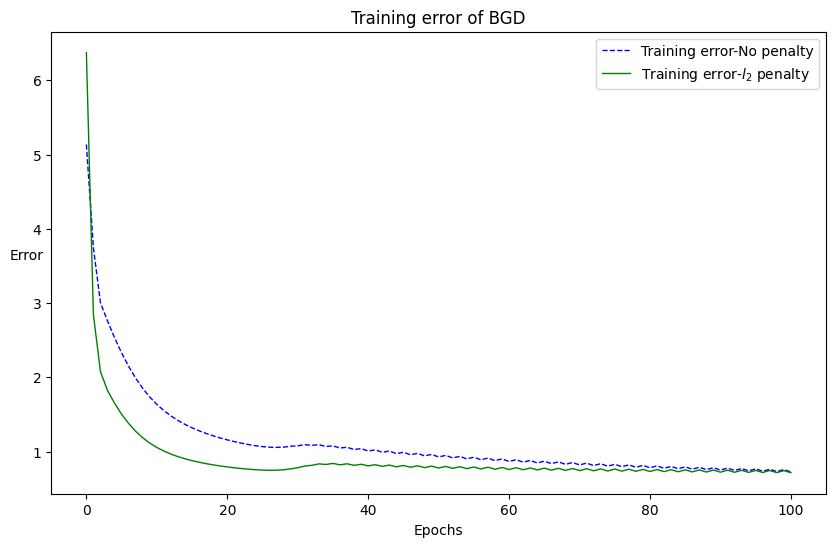

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(101), loss_path[:101], 'b--', lw=1, label="Training error-No penalty")
plt.plot(np.arange(101), loss_path_l2[:101], 'g', lw=1, label="Training error-$l_2$ penalty")

plt.xlabel("Epochs")
plt.ylabel("Error", rotation=0)
plt.legend()
plt.title("Training error of BGD")

savefig("2_regl2_vs_unreg_BGD")

Accuracy check

In [76]:
logits = X_b_val.dot(theta)
p_k = softmax(logits)
y_predict_l2 = One_hot_encoder(np.argmax(p_k, axis=1))

"accuracy", np.mean(y_predict_l2==y_val)

('accuracy', 0.9722222222222222)

Running this $l_2$ penalised algo on validation set

In [78]:
eta = 0.1 # higher eta than last time
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # Regularisation hyperparameter

theta_v = np.random.randn(5, 3)

loss_path_l2_val = []

for iteration in range(n_iterations):
    logits = X_b_val.dot(theta_v)
    
    p_k = softmax(logits)
    
    # the cost function of Softmax
    xentropy_loss = -np.mean(np.sum(y_val * np.log(p_k + epsilon), axis=1))
    # l2 penalty loss
    l2_loss = 1/2 * np.sum(np.square(theta_v[1:]))
    # total loss
    loss = xentropy_loss + alpha * l2_loss
    loss_path_l2_val.append(loss)
    
    if iteration%500 == 1:
        print(f"i={iteration}, loss={loss}")
        
    error = p_k - y_val
    
    # DIFFERENT graient vector
    gradients = 1/m * X_b_val.T.dot(error) + np.r_[np.zeros([1, 3]), alpha * theta_v[1:]]
    
    theta_v = theta_v - eta*gradients

theta

i=1, loss=7.103228174657977
i=501, loss=0.6226741311699022
i=1001, loss=0.6118537713919174
i=1501, loss=0.6029595650817615
i=2001, loss=0.5957127953233121
i=2501, loss=0.5897612347872598
i=3001, loss=0.5848367015624757
i=3501, loss=0.5807336263694609
i=4001, loss=0.5772930536249129
i=4501, loss=0.574391021307465


array([[ 3.20474499,  1.52228048, -4.74739075],
       [-0.11240079, -0.04697018,  0.15937097],
       [ 0.4012351 , -0.3106625 , -0.0905726 ],
       [-0.96942057,  0.15199904,  0.81742152],
       [-0.4084128 , -0.12680181,  0.53521462]])

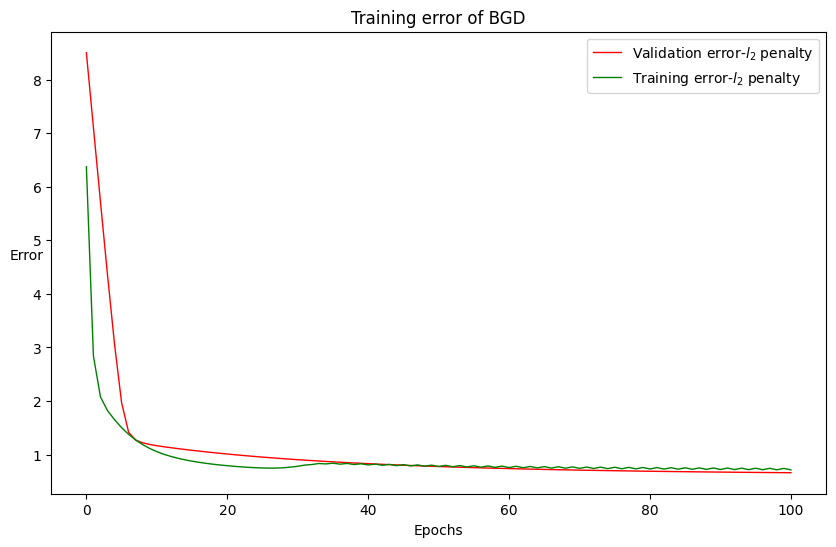

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(101), loss_path_l2_val[:101], 'r-', lw=1, label="Validation error-$l_2$ penalty")
plt.plot(np.arange(101), loss_path_l2[:101], 'g', lw=1, label="Training error-$l_2$ penalty")

plt.xlabel("Epochs")
plt.ylabel("Error", rotation=0)
plt.legend()
plt.title("Training error of BGD")

savefig("3_validation_vs_training_error_l2")

### BGD with $l_2$ penalty and *Early Stopping*

Since this is "too" early stopping, adding a `tolerence` of 10 consecutive terms

In [119]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # Regularisation hyperparameter
best_loss = np.infty
best_iteration = 0
# Dnt know why but some random behaviour in BGD too, therefore some tolerance precautions
tolerance = 10
bad_iter_times = 0 # counts no of times for consecutive 'bad_iteration'
theta_saved = False # flag if theta is saved in 'bad_iter' case
saved_theta = None

theta = np.random.randn(5, 3)

# 2 loss path for both training and validation sets
loss_path_ES_train = []
loss_path_ES_val = []

for iteration in range(n_iterations):
    
    #training part
    logits = X_b.dot(theta)
    p_k = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_train * np.log(p_k + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss_tr = xentropy_loss + alpha * l2_loss
    loss_path_ES_train.append(loss_tr)
    
    error = p_k - y_train
    gradients = 1/m * X_b.T.dot(error) + np.r_[np.zeros([1, 3]), alpha * theta[1:]]
    theta = theta - eta*gradients
    
    # validation part
    logits = X_b_val.dot(theta)
    p_k = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_val * np.log(p_k + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    loss_path_ES_val.append(loss)
    
    if iteration%500 == 1:
        print(f"i={iteration}, loss={loss}")
        
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        # tolerance precautions
        bad_iter_times = 0
        theta_saved = False
    else:
        bad_iter_times += 1
        if bad_iter_times < tolerance:
            if theta_saved == False:
                saved_theta = theta
                theta_saved = True
            pass
        else: # bad_iter_times >= tolerance
            best_iteration = iteration-1
            print(f"i={best_iteration}, loss={best_loss}")
            print(f"i={iteration}, loss={loss}")
            print("EARLY STOPPING!!!")
            # if saved_theta != None:
            theta = saved_theta
            break


i=1, loss=1.7086310889855179
i=501, loss=0.624708005142158
i=1001, loss=0.5891973365356182
i=1501, loss=0.5610912811486635
i=2001, loss=0.5392060609583414
i=2501, loss=0.5226515544146673
i=3001, loss=0.5109608323425819
i=3501, loss=0.5051181732845942
i=3616, loss=0.504949220857984
i=3617, loss=0.5049504374367046
EARLY STOPPING!!!


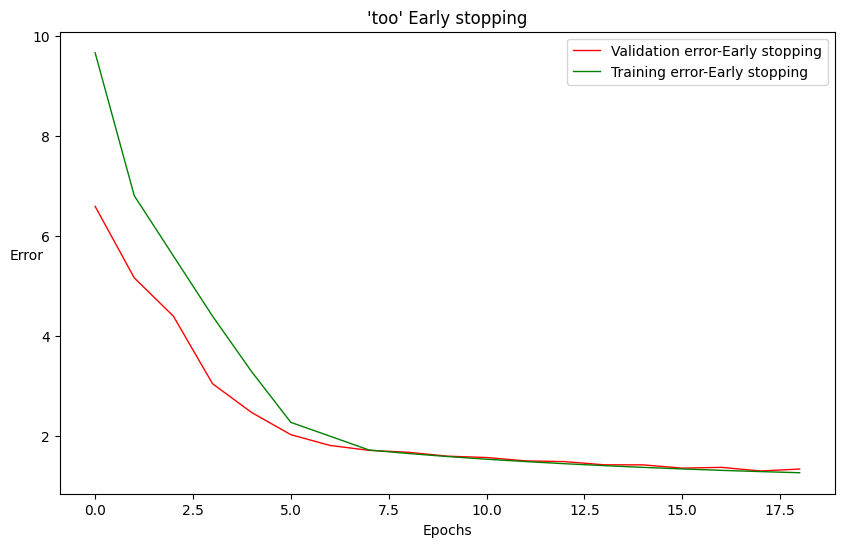

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(19), loss_path_ES_val[:19], 'r-', lw=1, label="Validation error-Early stopping")
plt.plot(np.arange(19), loss_path_ES_train[:19], 'g', lw=1, label="Training error-Early stopping")

plt.xlabel("Epochs")
plt.ylabel("Error", rotation=0)
plt.legend()
plt.title("'too' Early stopping")

savefig("4_too_early_stopping")

Accuracy check for Early Stopping model

In [116]:
X_b_test = np.c_[np.ones((len(X_test), 1)), X_test]


logits = X_b_test.dot(theta)
p_k = softmax(logits)
y_predict_l2 = One_hot_encoder(np.argmax(p_k, axis=1))

"accuracy", np.mean(y_predict_l2==y_test)

('accuracy', 0.9555555555555556)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(3600), loss_path_ES_val[:3600], 'r-o', lw=1, label="Validation error-Early stopping")
plt.plot(np.arange(3600), loss_path_ES_train[:3600], 'g', lw=1, label="Training error-Early stopping")
plt.plot([best_iteration for _ in range(10)], [x for x in range(10)], 'k--', lw=1, label=f"Best Epoch: {best_iteration}")

plt.xlabel("Epochs")
plt.ylabel("Error", rotation=0)
plt.legend()
plt.title("Fixed- Early stopping on BGD with $l_2$ penalty")

savefig("4_too_early_stopping")